The first thing we need to do is import some essential stuff. Theses have to be installed and are prerequisites.

In [1]:
import datetime
import time as time_module
import sys
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import theano
import matplotlib
import pymc3 as pm
import theano.tensor as tt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Then we import the covid19_inference module.

In [2]:
try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('..')
    import covid19_inference as cov19

We obtain the JHU data for Italy.

In [3]:
jhu = cov19.data_retrieval.JHU()
jhu.download_confirmed()

# extract confirmed from 20/02 to 03/05
bd = datetime.datetime(2020,2,21) # first date with >10 cases
ed = datetime.datetime(2020,5,3) # measures were relaxed and tests more available after
total_cases = jhu.get_confirmed(country = "Italy", begin_date= bd, end_date = ed )

In [4]:
new_cases_obs = np.diff(total_cases.to_numpy().flatten())
print(new_cases_obs)

[  42   93   74   93  131  202  233  240  566  342  466  587  769  778
 1247 1492 1797  977 2313    0 5198 3497 3590 3233 3526 4207 5322 5986
 6557 5560 4789 5249 5210 6203 5909 5974 5217 4050 4053 4782 4668 4585
 4805 4316 3599 3039 3836 4204 3951 4694 4092 3153 2972 2667 3786 3493
 3491 3047 2256 2729 3370 2646 3021 2357 2324 1739 2091 2086 1872 1965
 1900 1389]


For the choice of changing points, see https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Italy
- on 22/02, a lockdown of some areas and closure of schools and universities in many regions in the north were ordered
- on 01/03, nationwide measures, three zones
- 08/03, large regional lockdown in the north
- 10/03, nationwide lockdown
- 21/03 tighter measures, more economic activities closed
- 10/04 some businesses may reopen

All the parameters chosen in the following amount to a quick, naive application of the model to Italy. Delays are set as for Germany.



In [5]:
date_begin_data = bd
date_end_data   = ed
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_forecast = 16

prior_date_local_lockdown =  datetime.datetime(2020,2,22)
prior_date_three_zones =  datetime.datetime(2020,3,1)
prior_date_north_lockdown =  datetime.datetime(2020,3,8)
prior_date_complete_lockdown = datetime.datetime(2020,3,10)
prior_date_more_closures = datetime.datetime(2020,3,21)
prior_date_some_openings = datetime.datetime(2020,4,10)

change_points = [dict(pr_mean_date_transient = prior_date_local_lockdown,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 0.3,
                      pr_sigma_lambda = 1),
                dict(pr_mean_date_transient = prior_date_three_zones,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 0.2,
                      pr_sigma_lambda = 1),
                dict(pr_mean_date_transient = prior_date_north_lockdown,
                      pr_sigma_date_transient = 3, #less because of closeness to next changing point
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 1),
                dict(pr_mean_date_transient = prior_date_complete_lockdown,
                      pr_sigma_date_transient = 3,
                      pr_median_lambda = 1/12,
                      pr_sigma_lambda = 1),
                dict(pr_mean_date_transient = prior_date_more_closures,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 1/16,
                      pr_sigma_lambda = 1),
                dict(pr_mean_date_transient = prior_date_some_openings,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 1/14,
                      pr_sigma_lambda = 1)]

In [6]:
params_model = dict(new_cases_obs = new_cases_obs[:],
                    data_begin = date_begin_data,
                    fcast_len = num_days_forecast,
                    diff_data_sim = diff_data_sim,
                    N_population = 60.36e6) 

# The model is specified in a context. Each function in this context has access to the model parameters set
with cov19.Cov19Model(**params_model) as model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.lambda_t_with_sigmoids(pr_median_lambda_0 = 0.4,
                                                change_points_list = change_points)
    
    # Use this array to run the SIR model
    new_I_t = cov19.SIR(lambda_t_log, pr_median_mu=1/8)
    
    # Delay the cases by a lognormal reporting delay
    new_cases_inferred_raw = cov19.delay_cases(new_I_t, pr_median_delay=10, 
                                               pr_median_scale_delay=0.4)
    # delay as for Germany
    
    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    new_cases_inferred = cov19.week_modulation(new_cases_inferred_raw)
    
    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.student_t_likelihood(new_cases_inferred)


INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len

In [7]:
trace = pm.sample(model=model, tune=500, draws=500, init='advi+adapt_diag')

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
Average Loss = 636.16:  15%|█▌        | 30699/200000 [04:42<25:55, 108.82it/s]  
Convergence achieved at 30700
INFO     [pymc3.variational.inference] Convergence achieved at 30700
Interrupted at 30,699 [15%]: Average Loss = 734.14
INFO     [pymc3.variational.inference] Interrupted at 30,699 [15%]: Average Loss = 734.14
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, offset_modulation_rad, weekend_factor, delay_log, I_begin, mu, transient_len_6_log, transient_len_5_log, transient_len_4_log, transient_len_3_log, transient_len_2_log, transient_len_1_log, transient_day_6, transient_day_5, transient_day_4, transient_day_3, transient_day_2, transient_day_1, lambda_6_log, lambda_5_log, lambda_4_log, lambda_3_log, lambda_2_log, lambda_1_log, l

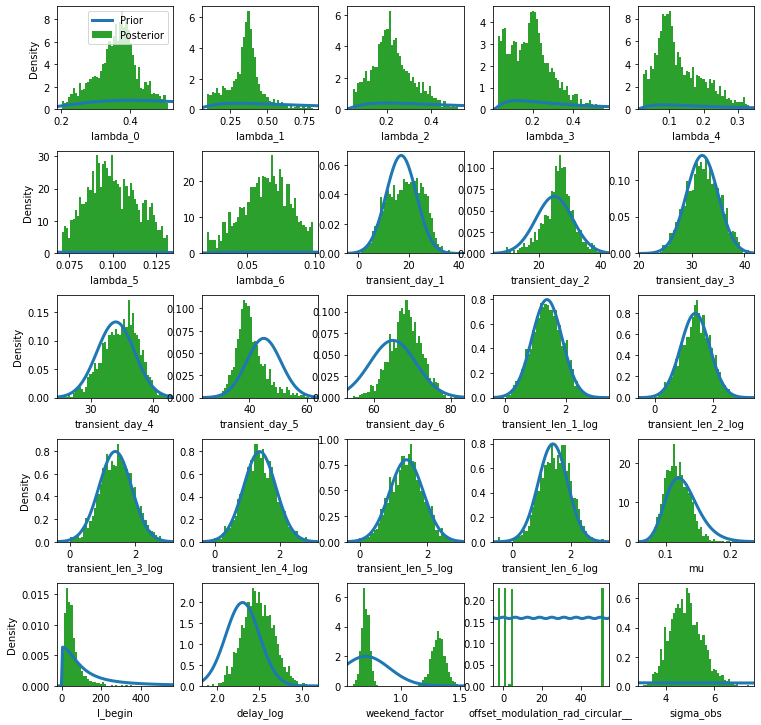

In [8]:
 varnames = cov19.plotting.get_all_free_RVs_names(model)
num_cols = 5
num_rows = int(np.ceil(len(varnames)/num_cols))
x_size = num_cols * 2.5
y_size = num_rows * 2.5

fig, axes = plt.subplots(num_rows, num_cols, figsize = (x_size, y_size),squeeze=False)
i_ax = 0
for i_row, axes_row in enumerate(axes):
    for i_col, ax in enumerate(axes_row):
        if i_ax >= len(varnames):
            ax.set_visible(False)
            continue 
        else:
            cov19.plotting.plot_hist(model, trace, ax, varnames[i_ax], 
                                     colors=('tab:blue', 'tab:green'),lambda_exp=True)
        if not i_col == 0:
            ax.set_ylabel('')
        if i_col == 0 and i_row == 0:
            ax.legend()
        i_ax += 1
fig.subplots_adjust(wspace=0.25, hspace=0.4)


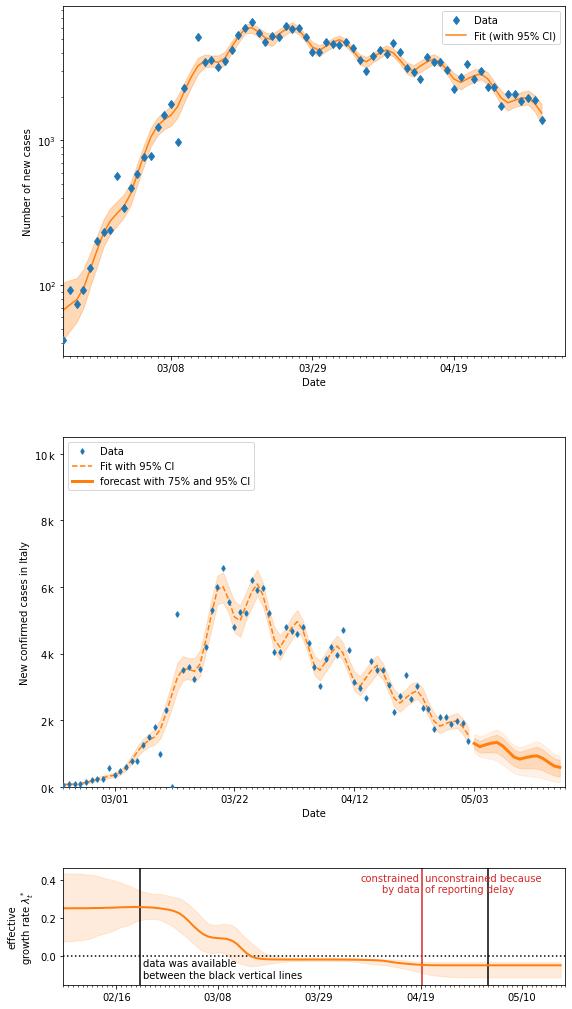

In [9]:
from importlib import reload
reload(cov19.plotting)

fig.subplots_adjust(wspace=0.25, hspace=0.4)
fig, axes = cov19.plotting.plot_cases(trace, new_cases_obs, bd - datetime.timedelta(days = diff_data_sim), diff_data_sim, country="Italy", big=True)

In [10]:
from covid19_inference import data_collection as cov19dc
lockdown_date = prior_date_complete_lockdown
lockdown_type = "confinement"
other_vars = {"bd": bd, "ed": ed, 
              "diff_data_sim": diff_data_sim, "num_days_forecast": num_days_forecast, 
              "lockdown_date": lockdown_date, "lockdown_type": lockdown_type,
              "tune": 500, "draws": 500}
cov19dc.update_collection("Italy", "JHU", trace, model.unobserved_RVs, change_points, other_vars)